## Практика

Подключаем библиотеки

In [2]:
from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
np.random.seed(42)
sns.set_style('whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

### Загрузка данных

In [4]:
path = Path('bbc')
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]                                  # Тему берём из папки
        lines = f.readlines()  
        heading = lines[0].strip()                              # Заголовок из первой строчки
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])    

### Конвертируем в дата фрейм

In [5]:
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Heading   2225 non-null   object
 2   Article   2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


### Создание трейн и тест датасетов

In [6]:
train_docs, test_docs = train_test_split(docs, 
                                         stratify=docs.Category, 
                                         test_size=50, 
                                         random_state=42)

train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [7]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: Category, dtype: int64

### Векторизация датасетов

In [45]:
vectorizer = TfidfVectorizer(max_df=0.2,  # максимальная частота
                             min_df=0.01, # минимальная частота
                             stop_words='english') 

train_dtm = vectorizer.fit_transform(train_docs.Article) # Convert a collection of raw documents to a matrix ofterm frequency–inverse document frequency
train_dtm

<2175x2907 sparse matrix of type '<class 'numpy.float64'>'
	with 205235 stored elements in Compressed Sparse Row format>

In [48]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2907 sparse matrix of type '<class 'numpy.float64'>'
	with 4649 stored elements in Compressed Sparse Row format>

### Токены / Термины

In [73]:
train_token_count = train_dtm.sum(0).A.squeeze()
# tokens = vectorizer.get_feature_names() -- устарело
tokens = vectorizer.get_feature_names_out()
word_count = pd.Series(train_token_count, index=tokens).sort_values(ascending=False)
word_count.head(10)

film       41.47
game       36.54
best       36.33
labour     32.75
music      30.97
company    29.73
election   28.09
england    28.08
market     27.67
party      27.44
dtype: float64

### PLSA

PLSA эквивалентно неотрицательному матричному разложению с помощью `KL`-дивергенции, поэтому мы можем использовать [sklearn.decomposition.NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) для решения нашей задачи. 

In [95]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components+1)]

nmf = NMF(n_components=n_components, 
          random_state=42, 
          solver='mu',                  # Multiplicative weight update method
          beta_loss='kullback-leibler', 
          max_iter=1000)
nmf.fit(train_dtm)

NMF(beta_loss='kullback-leibler', max_iter=1000, n_components=5,
    random_state=42, solver='mu')

Посмотрим на reconstruction error (ошибку восстановления?). 

In [96]:
nmf.reconstruction_err_

311.26477396504123

### Изучим темы

In [76]:
train_doc_topics = nmf.transform(train_dtm)
train_doc_topics.shape

(2175, 5)

In [114]:
i = randint(0, len(train_docs))
train_docs.iloc[i, :2].append(pd.Series(train_doc_topics[i], 
                                         index=topic_labels))  # get Category and Heading and append train doc topics

Category                            Politics
Heading     UK needs tax cuts, Tories insist
Topic 1                                 0.01
Topic 2                                 0.00
Topic 3                                 0.14
Topic 4                                 0.00
Topic 5                                 0.00
dtype: object

In [78]:
train_result = pd.DataFrame(data=train_doc_topics,
                   columns=topic_labels,
                   index=train_docs.Category)

In [79]:
test_eval = pd.DataFrame(data=nmf.transform(test_dtm), 
                         columns=topic_labels,
                         index=test_docs.Category)

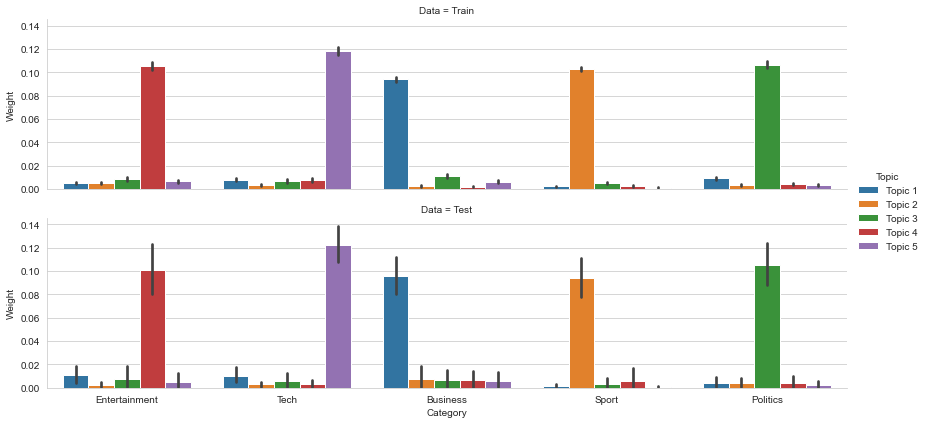

In [80]:
result = pd.melt(train_result.assign(Data='Train')
                 .append(test_eval.assign(Data='Test'))
                 .reset_index(),
                 id_vars=['Data', 'Category'],
                 var_name='Topic',
                 value_name='Weight')

g =sns.catplot(x='Category', 
               y='Weight', 
               hue='Topic', 
               row='Data', 
               kind='bar', 
               data=result, 
               height=3,
               aspect=4)

### Самые главные термины

In [81]:
topics = pd.DataFrame(nmf.components_.T,
                      index=tokens,
                      columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.00,0.00,0.00,0.89,0.00
game,0.00,0.47,0.00,0.03,0.15
best,0.04,0.14,0.02,0.54,0.00
labour,0.00,0.00,0.58,0.00,0.00
music,0.00,0.00,0.00,0.34,0.28
company,0.40,0.00,0.00,0.05,0.09
election,0.00,0.00,0.50,0.00,0.00
england,0.03,0.41,0.05,0.00,0.00
market,0.37,0.00,0.00,0.00,0.12
party,0.00,0.00,0.48,0.00,0.00


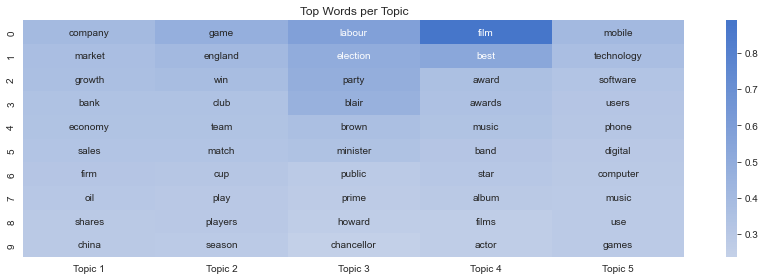

In [82]:
fig, ax = plt.subplots(figsize=(12, 4))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals), 
            annot=top_words, 
            fmt = '', 
            center=0, 
            cmap=sns.diverging_palette(0, 255, sep=1, n=256), 
            ax=ax)
ax.set_title('Top Words per Topic')
fig.tight_layout()

In [83]:
topics = pd.DataFrame(nmf.components_.T,
                      index=words,
                      columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
000m,0.00,0.07,0.00,0.00,0.00
10,0.12,0.08,0.04,0.11,0.06
100,0.06,0.01,0.04,0.02,0.05
100m,0.02,0.05,0.00,0.01,0.00
11,0.08,0.03,0.03,0.08,0.01


In [84]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,company,game,labour,film,mobile
1,market,england,election,best,technology
2,growth,win,party,award,software
3,bank,club,blair,awards,users
4,economy,team,brown,music,phone
5,sales,match,minister,band,digital
6,firm,cup,public,star,computer
7,oil,play,prime,album,music
8,shares,players,howard,films,use
9,china,season,chancellor,actor,games
